In [38]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from ISLP import load_data

In [5]:
Smarket = load_data("Smarket")
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [8]:
Smarket.select_dtypes(include="number").corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


<Axes: >

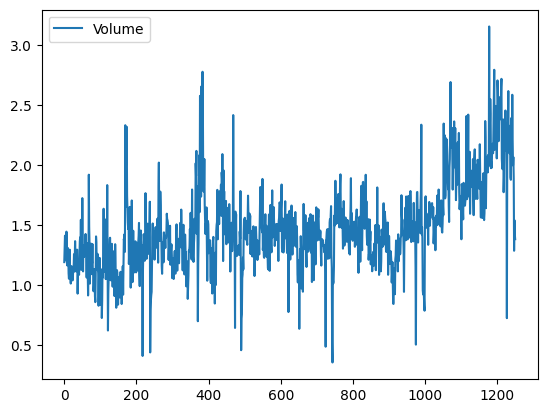

In [11]:
Smarket.plot(y="Volume")

# Functions

In [144]:
def print_confusion_matrix(y_true, y_pred, normalize=None):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize).T
    labels = np.unique(y_true)
    ConfusionMatrixDisplay(cm, display_labels=labels).plot()
    plt.title("Confusion Matrix")
    plt.xlabel("True Label")
    plt.ylabel("Predict Label")
    plt.tight_layout()

    return cm

# Logistic Regression

In [145]:
X = Smarket.drop(columns=["Today", "Direction", "Year"])
X = sm.add_constant(X)
y = Smarket["Direction"] == "Up"

glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                 1250
Model:                            GLM   Df Residuals:                     1243
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -863.79
Date:                Wed, 27 Nov 2024   Deviance:                       1727.6
Time:                        12:46:49   Pearson chi2:                 1.25e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002868
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.6

There is no clear association between the Lag variables and the direction, even though Lag1 has the smallest p-value out of all the other variables. 

In [146]:
probabilities = results.predict()
probabilities[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [147]:
labels = np.array(["Down"] * len(X))
labels[probabilities > 0.5] = "Up"

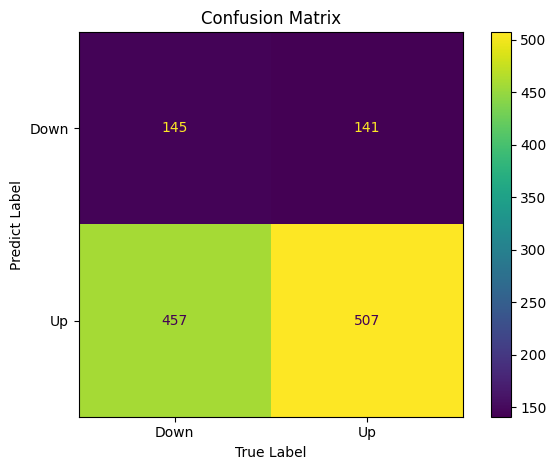

In [148]:
cm = print_confusion_matrix(Smarket.Direction, labels)

In [149]:
# Average training accuracy and error rate
training_acc = (145 + 507) / cm.sum()
training_err = 1 - training_acc

training_acc, training_err

(0.5216, 0.47840000000000005)

Instead of using the whole dataset for training, we split it

In [150]:
train_mask = (Smarket["Year"] < 2005)
train = Smarket.loc[train_mask]
test = Smarket.loc[~train_mask]
train.shape, test.shape

((998, 9), (252, 9))

In [151]:
X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test, y_test = X.loc[~train_mask], y.loc[~train_mask]
glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())

results = glm.fit()
print(results.summary())

probabilities = results.predict(exog=X_test)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                  998
Model:                            GLM   Df Residuals:                      991
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -690.55
Date:                Wed, 27 Nov 2024   Deviance:                       1381.1
Time:                        12:46:49   Pearson chi2:                     998.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002162
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1912      0.334      0.573      0.5

In [152]:
labels_train, labels_test = Smarket.Direction.loc[train_mask], Smarket.Direction.loc[~train_mask]

In [153]:
labels_pred = np.array(["Down"] * len(X_test))
labels_pred[probabilities > 0.5] = "Up"

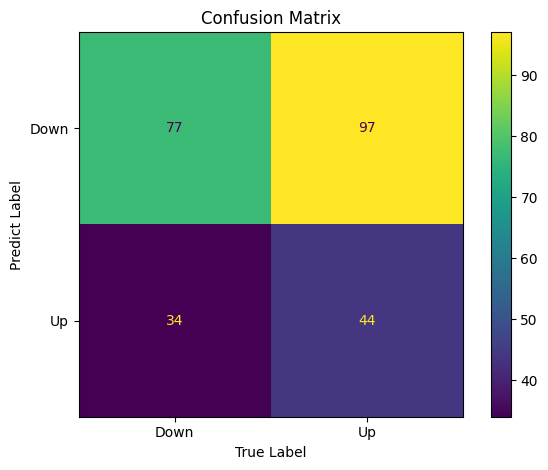

In [154]:
cm = print_confusion_matrix(labels_test, labels_pred)

In [155]:
# Test accuracy and error rates
np.mean(labels_pred == labels_test), np.mean(labels_pred != labels_test)

(0.4801587301587302, 0.5198412698412699)

Let us only use Lag1 and Lag2 now since they have the smallest p-values out of all the variables

In [161]:
X = Smarket.loc[:, ["Lag1", "Lag2"]]
X = sm.add_constant(X)
X_train, X_test = X.loc[train_mask], X.loc[~train_mask]

glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())

results = glm.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Direction   No. Observations:                  998
Model:                            GLM   Df Residuals:                      995
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -690.70
Date:                Wed, 27 Nov 2024   Deviance:                       1381.4
Time:                        12:54:10   Pearson chi2:                     998.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001865
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0322      0.063      0.508      0.6

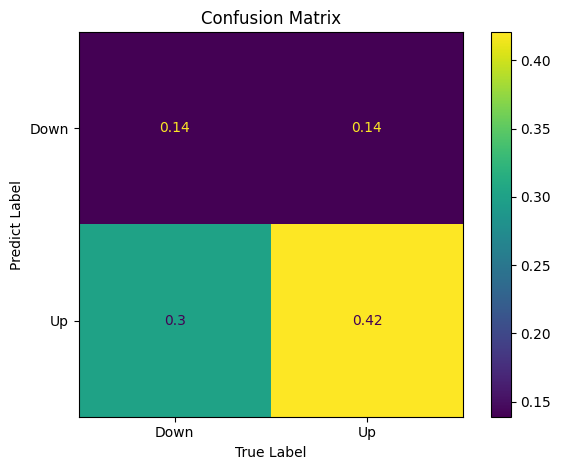

In [163]:
probabilities = results.predict(exog=X_test)
labels_pred = np.array(["Down"] * len(X_test))
labels_pred[probabilities > 0.5] = "Up"

cm = print_confusion_matrix(labels_test, labels_pred, normalize="all")

In [164]:
# Test accuracy and precision
print("Accuracy:", cm[0, 0] + cm[1, 1])
print("Precision:", cm[1, 1]/(cm[1, 0] + cm[1, 1]))

Accuracy: 0.5595238095238095
Precision: 0.5824175824175825


The logistic regression model is not much better than random guessing, but has a decent precision. So, one strategy can be to trade when the model predicts that the market will move up, and to not trade when it predicts a decrease.

# Linear Discriminant Analysis

In [165]:
lda = LDA(store_covariance=True)

In [166]:
X = Smarket.loc[:, ["Lag1", "Lag2"]]
X_train, X_test = X.loc[train_mask], X.loc[~train_mask]
y = Smarket.Direction
y_train, y_test = y.loc[train_mask], y.loc[~train_mask]

lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [168]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [167]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

The previous two days' returns have a tendency to be negative when the market goes up, and positive when the market goes down. 

In [170]:
# Prior probabilities of the classes
lda.priors_

array([0.49198397, 0.50801603])

In [171]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

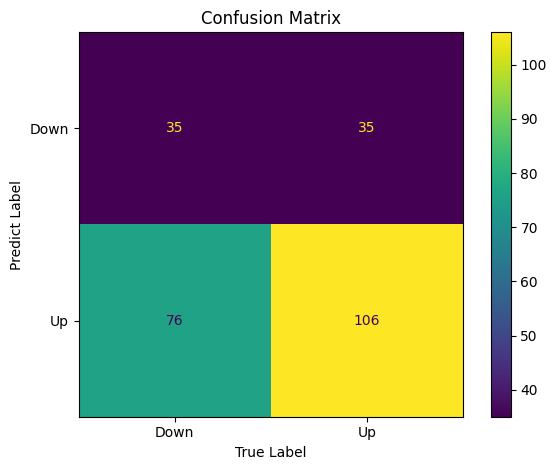

In [173]:
y_pred = lda.predict(X_test)
cm = print_confusion_matrix(y_test, y_pred)

# Quadratic Discriminant Analysis

In [174]:
qda = QDA(store_covariance=True)

In [175]:
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [176]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [177]:
qda.covariance_

[array([[ 1.50662277, -0.03924806],
        [-0.03924806,  1.53559498]]),
 array([[ 1.51700576, -0.02787349],
        [-0.02787349,  1.49026815]])]

In [178]:
qda.scalings_

[array([1.56294495, 1.47927279]), array([1.53455065, 1.47272326])]

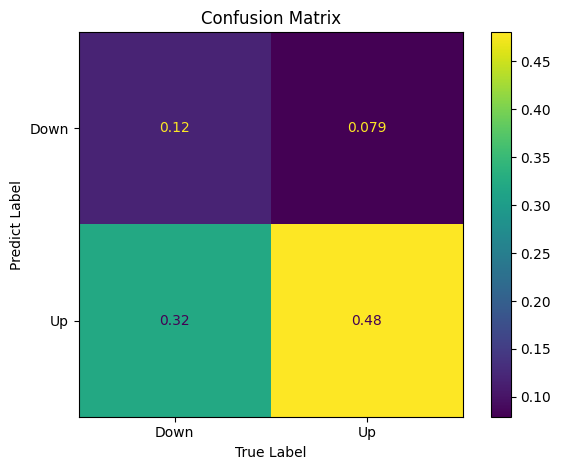

In [180]:
y_pred = qda.predict(X_test)
cm = print_confusion_matrix(y_test, y_pred, normalize="all")

In [181]:
print("Accuracy:", cm[0, 0] + cm[1, 1])
print("Precision:", cm[1, 1] / (cm[1, 0] + cm[1, 1]))

Accuracy: 0.5992063492063492
Precision: 0.599009900990099


QDA is able to provide a much better accuracy and precision for this dataset

# Naive Bayes